# Marketing Analytics: Predicting Customer Churn in Python 
## 利用Python分析与预测运营商客户流失

### 背景

### 提出问题
1. 理解用户数据的特征，分析其与流失的关系
2. 用户分为流失和留存，通过理解这两类的差异，更好的了解客户流失的驱动因素是什么
3. 找到合适的模型预测用户流失情况

### 数据集
数据集来自’Telco'电信运营商用户数据集，包含以下内容：
1. 上个月流失的用户 - ‘Churn'列
2. 用户签订的服务 - 电话服务，多线服务，上网服务，网络安全，备份服务，设备保护，技术支持，在线电视和电影
3. 用户账户信息 - 注册月数，合同期限，支付方式，电子账单，月消费额，总消费额
4. 用户个人信息 - 性别，年龄（是否是老年用户），是否结婚



### 数据清洗
数据清洗的“完全合一”规则：

1. 完整性：单条数据是否存在空值，统计的字段是否完善。
2. 全面性：观察某一列的全部数值，通过常识来判断该列是否有问题，比如：数据定义、单位标识、数据本身。
3. 合法性：数据的类型、内容、大小的合法性。比如数据中是否存在非ASCII字符，性别存在了未知，年龄超过了150等。
4. 唯一性：数据是否存在重复记录，因为数据通常来自不同渠道的汇总，重复的情况是常见的。行数据、列数据都需要是唯一的。

导入工具包

In [105]:
import pandas as pd
import numpy as np

导入数据集

In [106]:
telco = pd.read_csv('telco.csv')

查看数据集大小和结构

In [107]:
#查看数据集大小
telco.shape
#运行结果（7043，21）
#查看前五行数据：
telco.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [108]:
#查看数据集结构
telco.info()
#telco.dtypes()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


通过.info()可以了解数据集的结构以及不同columns的特征，大致可以将数据分为以下三方面：
1. 用户属性：CustomerID, gender, SeniorCitizen, Partner, Dependents
2. 服务: Tenure, PhoneService,Multiplelines, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StramingTV and movies
3. 合约: Contract, PaperlessBilling, PaymentMethod, MonthlyCharges, TotalCharges

其中通过观察发现，总消费额TotalCharges为字符串形式，应转为浮点型或数字型

In [109]:
# Converting Total Charges to a numerical data type.
telco.TotalCharges = pd.to_numeric(telco.TotalCharges, errors='coerce')

查看是否有缺失值

In [110]:
telco.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

经过观察，发现这11个用户‘tenure’（入网时长）为0，推测是当月新入网用户。 根据一般经验，用户即使在注册的当月流失，也需缴纳当月费用。因此将这11个用户入网时长改为1，将总消费额填充为月消费额，符合实际情况。

In [111]:
#将总消费额填充为月消费额
telco.loc[:,'TotalCharges'].replace(to_replace=np.nan,value=telco.loc[:,'MonthlyCharges'],inplace=True)
#查看是否替换成功
print(telco[telco['tenure']==0][['tenure','MonthlyCharges','TotalCharges']])

      tenure  MonthlyCharges  TotalCharges
488        0           52.55         52.55
753        0           20.25         20.25
936        0           80.85         80.85
1082       0           25.75         25.75
1340       0           56.05         56.05
3331       0           19.85         19.85
3826       0           25.35         25.35
4380       0           20.00         20.00
5218       0           19.70         19.70
6670       0           73.35         73.35
6754       0           61.90         61.90


In [112]:
# 将‘tenure’入网时长从0修改为1
telco.loc[:,'tenure'].replace(to_replace=0,value=1,inplace=True)
print(pd.isnull(telco['TotalCharges']).sum())
print(telco['TotalCharges'].dtypes)

0
float64


In [113]:
# 最后获取数据类型的描述统计信息
telco.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.372710,64.761692,2279.798992
std,0.368612,24.557454,30.090047,2266.730170
min,0.000000,1.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,398.550000
50%,0.000000,29.000000,70.350000,1394.550000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


### 可视化分析
在应用算法之前，通过可视化方法了解数据集中变量的分布。

导入工具包

In [129]:
# Import matplotlib and seaborn
import seaborn as sns # For creating plots
import matplotlib.ticker as mtick # For specifying the axes tick format 
import matplotlib.pyplot as plt

通过查看数据集中最关键的‘Churn’分布，流失率为26.54%

CUSTOMERS %CHURN:
No     73.46
Yes    26.54
Name: Churn, dtype: float64


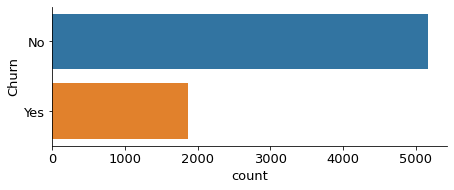

In [168]:
print("CUSTOMERS %CHURN:")
print(round(telco['Churn'].value_counts(normalize=True) * 100,2))
ax = sns.catplot(y="Churn", kind="count", data=telco, height=2.6, aspect=2.5, orient='h')

根据之前的数据分类，分别查看它们与'Churn'的关系

#### 1.用户属性

1.1 年龄

Text(0.5, 1.0, '% of Senior Citizens')

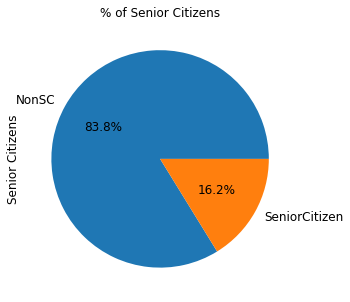

In [169]:
ax = (telco['SeniorCitizen'].value_counts()*100.0 /len(telco))\
.plot.pie(autopct='%.1f%%', labels = ['NonSC', 'SeniorCitizen'],figsize =(5,5), fontsize = 12 )                                                                           
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel('Senior Citizens',fontsize = 12)
ax.set_title('% of Senior Citizens', fontsize = 12)

通过数据比对发现，老年人占比16.2%，用户以年轻人为主。进一步观察留存分布。

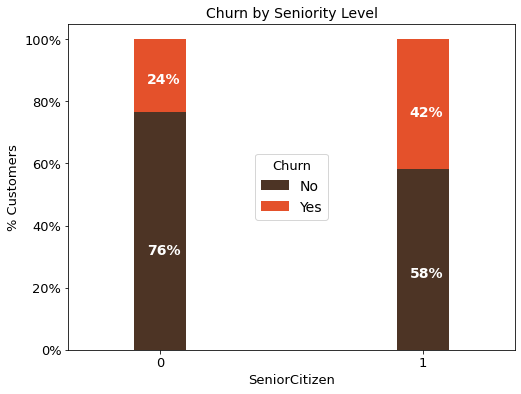

In [214]:
seniority_churn = telco.groupby(['SeniorCitizen','Churn']).size().unstack()
colors = ['#4D3425','#E4512B']
ax = (seniority_churn.T*100.0 / seniority_churn.T.sum()).T.plot(kind='bar',
                                                                width = 0.2,
                                                                stacked = True,
                                                                rot = 0, 
                                                                figsize = (8,6),
                                                                color = colors)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.legend(loc='center',prop={'size':14},title = 'Churn')
ax.set_ylabel('% Customers')
ax.set_title('Churn by Seniority Level',size = 14)

# Code to add the data labels on the stacked bar chart
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0f}%'.format(height), (p.get_x()+.25*width, p.get_y()+.4*height),
                color = 'white',
               weight = 'bold',size =14)

小结：老年人虽然占比16%，然而流失率却高达42%，几乎是年轻人的两倍（23%）

1.2 性别

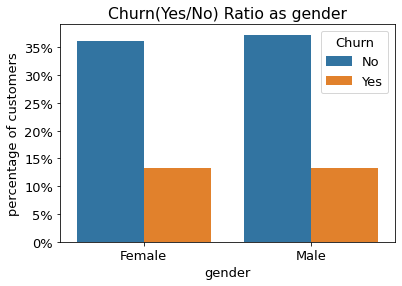

In [204]:

def barplot_percentages(feature,orient='v',axis_name="percentage of customers"):
    ratios = pd.DataFrame()
    g = (telco.groupby(feature)["Churn"].value_counts()/len(telco)).to_frame()
    g.rename(columns={"Churn":axis_name},inplace=True)
    g.reset_index(inplace=True)

    #print(g)
    if orient == 'v':
        ax = sns.barplot(x=feature, y= axis_name, hue='Churn', data=g, orient=orient)
        ax.set_yticklabels(['{:,.0%}'.format(y) for y in ax.get_yticks()])
        plt.rcParams.update({'font.size': 13})
        #plt.legend(fontsize=10)
    else:
        ax = sns.barplot(x= axis_name, y=feature, hue='Churn', data=g, orient=orient)
        ax.set_xticklabels(['{:,.0%}'.format(x) for x in ax.get_xticks()])
        #plt.legend(fontsize=10)
    plt.title('Churn(Yes/No) Ratio as {0}'.format(feature))
    plt.show()
barplot_percentages("gender")

小结：
性别对流失没有什么影响。

1.3 伴侣和家属情况

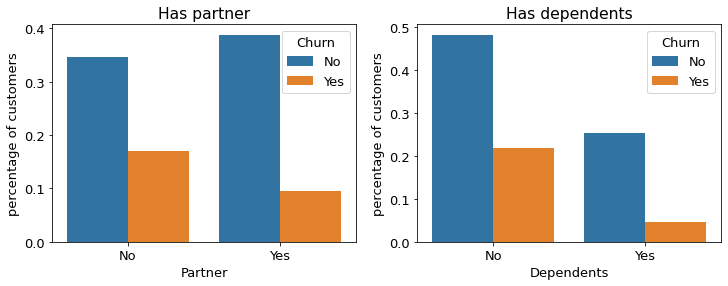

In [205]:
fig, axis = plt.subplots(1, 2, figsize=(12,4))
axis[0].set_title("Has partner")
axis[1].set_title("Has dependents")
axis_y = "percentage of customers"
# Plot Partner column
gp_partner = telco.groupby('Partner')["Churn"].value_counts()/len(telco)
gp_partner = gp_partner.to_frame().rename({"Churn": axis_y}, axis=1).reset_index()
ax = sns.barplot(x='Partner', y= axis_y, hue='Churn', data=gp_partner, ax=axis[0])
# Plot Dependents column
gp_dep = telco.groupby('Dependents')["Churn"].value_counts()/len(telco)
gp_dep = gp_dep.to_frame().rename({"Churn": axis_y}, axis=1).reset_index()
ax = sns.barplot(x='Dependents', y= axis_y, hue='Churn', data=gp_dep, ax=axis[1])

小结：
A. 没有伴侣的用户流失率较高
B. 没有家属的用户流失率较高



#### 2. 用户账户信息

2.1 注册时长，月消费额和总消费额都是数值型数据，可以使用核密度去估计它们的分布情况

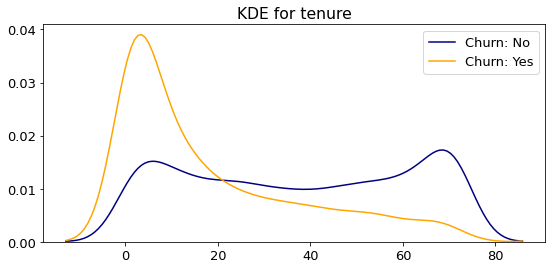

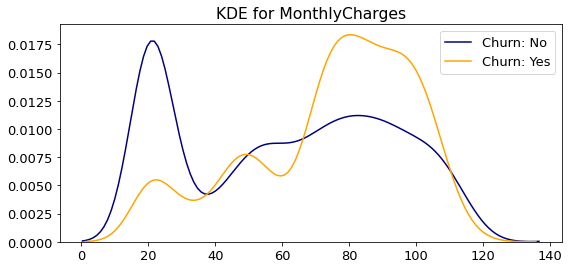

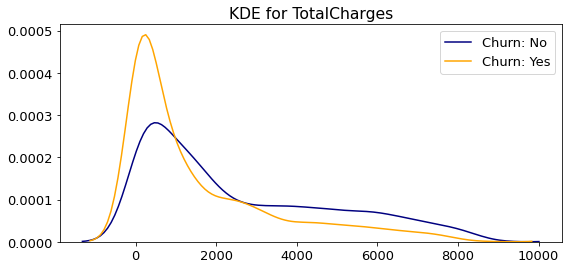

In [206]:
# Kernel density estimaton核密度估计
def kdeplot(feature):
    plt.figure(figsize=(9, 4))
    plt.title("KDE for {}".format(feature))
    ax0 = sns.kdeplot(telco[telco['Churn'] == 'No'][feature].dropna(), color= 'navy', label= 'Churn: No')
    ax1 = sns.kdeplot(telco[telco['Churn'] == 'Yes'][feature].dropna(), color= 'orange', label= 'Churn: Yes')
kdeplot('tenure')
kdeplot('MonthlyCharges')
kdeplot('TotalCharges')

小结：

A. 注册时间越久越不容易流失

B. 月消费额在70-110的用户容易流失

C. 总消费额低于2000的用户容易流失

2.2 合约情况

Text(0.5, 1.0, 'Two Year Contract')

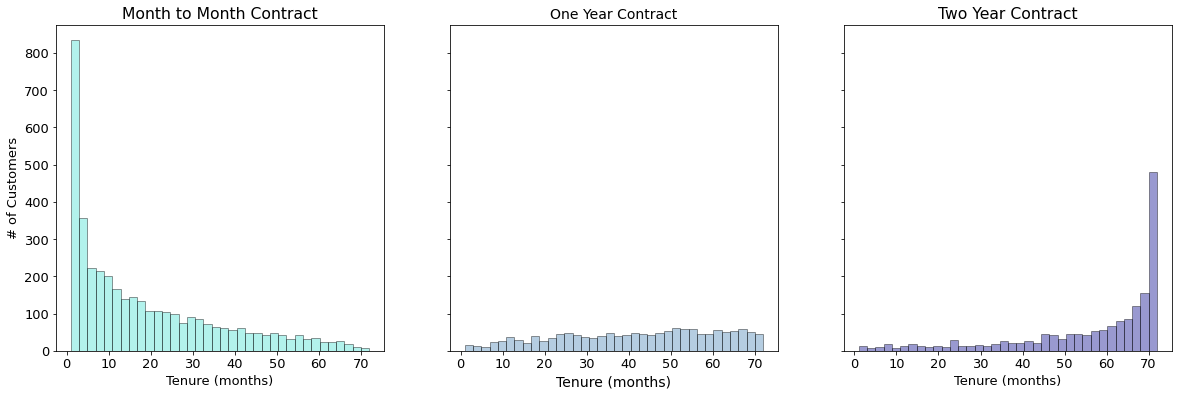

In [207]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, sharey = True, figsize = (20,6))

ax = sns.distplot(telco[telco['Contract']=='Month-to-month']['tenure'],
                   hist=True, kde=False,
                   bins=int(180/5), color = 'turquoise',
                   hist_kws={'edgecolor':'black'},
                   kde_kws={'linewidth': 4},
                 ax=ax1)
ax.set_ylabel('# of Customers')
ax.set_xlabel('Tenure (months)')
ax.set_title('Month to Month Contract')

ax = sns.distplot(telco[telco['Contract']=='One year']['tenure'],
                   hist=True, kde=False,
                   bins=int(180/5), color = 'steelblue',
                   hist_kws={'edgecolor':'black'},
                   kde_kws={'linewidth': 4},
                 ax=ax2)
ax.set_xlabel('Tenure (months)',size = 14)
ax.set_title('One Year Contract',size = 14)

ax = sns.distplot(telco[telco['Contract']=='Two year']['tenure'],
                   hist=True, kde=False,
                   bins=int(180/5), color = 'darkblue',
                   hist_kws={'edgecolor':'black'},
                   kde_kws={'linewidth': 4},
                 ax=ax3)

ax.set_xlabel('Tenure (months)')
ax.set_title('Two Year Contract')

小结：
按月签订的客户大部分分布在注册时长为1-2个月之间，而两年合约的用户在网时长大部分持续了70个月。说明合约签订越久，客户的忠诚度越高。

2.3 支付方式

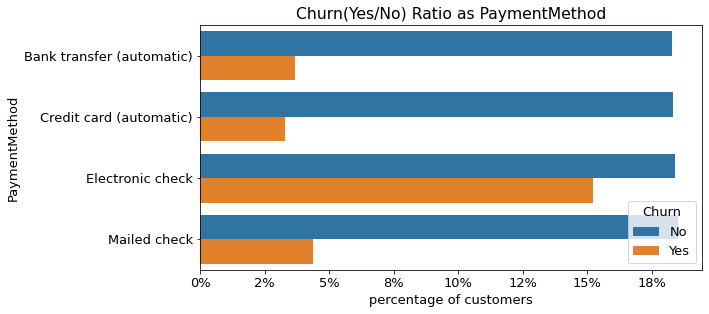

In [213]:
plt.figure(figsize=(9, 4.5))
barplot_percentages("PaymentMethod",'h')

小结：
使用电子支付的用户留存率最低，推断或许使用体验一般。

In [217]:
cols = ["OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies"]
df= pd.melt(telco[telco["InternetService"] != "No"][cols]).rename({'value': 'Has service'}, axis=1)
print(df)

              variable Has service
0       OnlineSecurity          No
1       OnlineSecurity         Yes
2       OnlineSecurity         Yes
3       OnlineSecurity         Yes
4       OnlineSecurity          No
...                ...         ...
33097  StreamingMovies         Yes
33098  StreamingMovies         Yes
33099  StreamingMovies          No
33100  StreamingMovies          No
33101  StreamingMovies         Yes

[33102 rows x 2 columns]


In [223]:
cols = ["OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies"]
print(telco[telco["InternetService"]!='NO'][cols])

     OnlineSecurity OnlineBackup DeviceProtection TechSupport StreamingTV  \
0                No          Yes               No          No          No   
1               Yes           No              Yes          No          No   
2               Yes          Yes               No          No          No   
3               Yes           No              Yes         Yes          No   
4                No           No               No          No          No   
...             ...          ...              ...         ...         ...   
7038            Yes           No              Yes         Yes         Yes   
7039             No          Yes              Yes          No         Yes   
7040            Yes           No               No          No          No   
7041             No           No               No          No          No   
7042            Yes           No              Yes         Yes         Yes   

     StreamingMovies  
0                 No  
1                 No  
2     